In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [3]:
!wget $data -O data.csv

--2023-10-17 17:41:27--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 954.59K  --.-KB/s    in 0.03s   

2023-10-17 17:41:28 (33.2 MB/s) - ‘data.csv’ saved [977501/977501]



In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.columns = df.columns.str.lower().str.replace(' ','_')

categorial_cols = list(df.dtypes[df.dtypes == 'object'].index)

for col in categorial_cols:
    df[col] = df[col].str.lower().str.replace(' ', '_')
# Convert total_charges to numerical values, ignore errors as NA
total_charges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = total_charges
df.totalcharges = df.totalcharges.fillna(0)
df.head().T
# Filter dataframe by specific column, pick specific columns
df[df['totalcharges'].isnull()][['customerid', 'totalcharges']]
df.churn = (df.churn == 'yes').astype('int')
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values


del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [7]:
categorial = ['gender', 'seniorcitizen', 'partner', 'dependents',
     'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [8]:
from sklearn.feature_extraction import DictVectorizer

In [9]:
train_dicts = df_train[categorial + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorial + numerical].to_dict(orient='records')
# only apply transform, already fit on training data
X_val = dv.transform(val_dicts)

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
lr = LogisticRegression()

## Training the model

In [12]:
lr.fit(X_train, y_train)
#Hard predictions
lr.predict(X_train)
# Soft predictions
y_pred = lr.predict_proba(X_train)[:,1]

In [13]:
y_val_pred = lr.predict_proba(X_val)[:,1]
y_val_pred
churn_decision = (y_pred >= 0.5)
churn_decision_val = (y_val_pred >= 0.5)

In [14]:
(y_val == churn_decision_val).mean()

0.8034066713981547

In [15]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_train
df_pred['correct'] = df_pred.actual == df_pred.prediction
df_pred

,probability,prediction,actual,correct
0,0.095477,0,0,True
1,0.679322,1,0,False
2,0.633674,1,1,True
3,0.717521,1,0,False
4,0.047681,0,0,True
...,...,...,...,...
4220,0.132772,0,0,True
4221,0.304563,0,0,True
4222,0.531617,1,1,True
4223,0.042544,0,0,True


## Confusion table

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [19]:
threshold = 0.5
predict_positive = (y_val_pred >= threshold)
predict_negative = (y_val_pred < threshold)

In [20]:
actual_positive[:5]

array([False, False, False,  True, False])

In [21]:
predict_positive[:5]

array([False, False, False,  True, False])

In [22]:
tn = (predict_negative & actual_negative).sum()
tp = (predict_positive & actual_positive).sum()
tp

210

In [23]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()
fn

176

In [24]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

In [25]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Accuracy

In [26]:
accuracy = ( tp + tn ) / ( tn + fp + fn + tp)
accuracy

0.8034066713981547

## Precision
- how many postive predictions are correct

In [27]:
p = tp / ( tp + fp )
p

0.6752411575562701

In [28]:
recall = tp/(tp+fn)
recall
print('failed to identify %s' %(1 - recall))

failed to identify 0.4559585492227979


In [29]:
def calc_tpr_fpr(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        threshold = t
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= threshold)
        predict_negative = (y_pred < threshold)

        tn = (predict_negative & actual_negative).sum()
        tp = (predict_positive & actual_positive).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tn, fp, fn, tp))

    columns = ['threshold', 'tn', 'fp', 'fn', 'tp']
    df_scores = pd.DataFrame(scores, columns = columns)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores
df_scores = calc_tpr_fpr(y_val, y_val_pred)
# Each 10th records
df_scores[::10]
     

,threshold,tn,fp,fn,tp,tpr,fpr
0,0.0,0,1023,0,386,1.000000,1.000000
10,0.1,467,556,20,366,0.948187,0.543500
20,0.2,667,356,53,333,0.862694,0.347996
30,0.3,787,236,102,284,0.735751,0.230694
40,0.4,857,166,137,249,0.645078,0.162268
50,0.5,922,101,176,210,0.544041,0.098729
60,0.6,970,53,236,150,0.388601,0.051808
70,0.7,1003,20,310,76,0.196891,0.019550
80,0.8,1022,1,373,13,0.033679,0.000978
90,0.9,1023,0,386,0,0.000000,0.000000


---
Random model prediction

In [30]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size=len(y_val))

((y_rand >= 0.5) == y_val).mean()

df_rand = calc_tpr_fpr(y_val, y_rand)

In [31]:
df_rand[::10]

,threshold,tn,fp,fn,tp,tpr,fpr
0,0.0,0,1023,0,386,1.000000,1.000000
10,0.1,100,923,39,347,0.898964,0.902248
20,0.2,201,822,79,307,0.795337,0.803519
30,0.3,299,724,110,276,0.715026,0.707722
40,0.4,399,624,149,237,0.613990,0.609971
50,0.5,505,518,184,202,0.523316,0.506354
60,0.6,614,409,225,161,0.417098,0.399804
70,0.7,721,302,265,121,0.313472,0.295210
80,0.8,817,206,308,78,0.202073,0.201369
90,0.9,922,101,346,40,0.103627,0.098729


## Ideal model

In [32]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos

(1023, 386)

In [33]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal_pred = np.linspace(0,1,  len(y_val ))

((y_ideal_pred >= 0.726) == y_ideal).mean()
## the best threshold to make prediction decision
1 - y_val.mean()

0.7260468417317246

In [34]:
df_ideal = calc_tpr_fpr(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tn,fp,fn,tp,tpr,fpr
0,0.0,0,1023,0,386,1.000000,1.000000
10,0.1,141,882,0,386,1.000000,0.862170
20,0.2,282,741,0,386,1.000000,0.724340
30,0.3,423,600,0,386,1.000000,0.586510
40,0.4,564,459,0,386,1.000000,0.448680
50,0.5,704,319,0,386,1.000000,0.311828
60,0.6,845,178,0,386,1.000000,0.173998
70,0.7,986,37,0,386,1.000000,0.036168
80,0.8,1023,0,104,282,0.730570,0.000000
90,0.9,1023,0,245,141,0.365285,0.000000


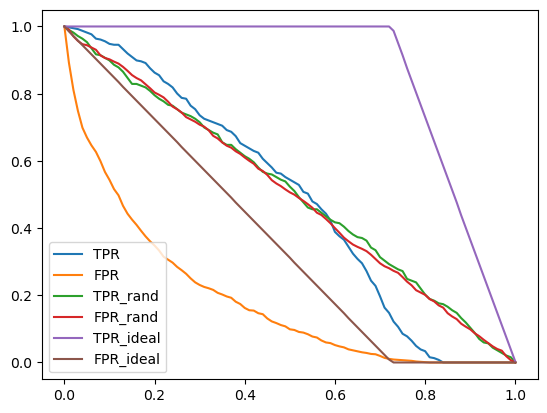

In [35]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

plt.plot(df_rand.threshold, df_rand.tpr, label='TPR_rand')
plt.plot(df_rand.threshold, df_rand .fpr, label='FPR_rand')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR_ideal')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR_ideal')
plt.legend()

Text(0, 0.5, 'TPR')

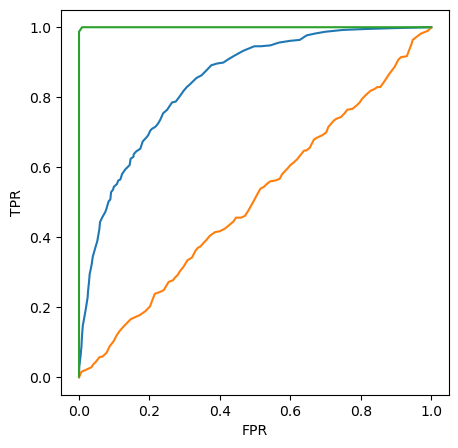

In [36]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

## ROC from sklearn metrics

In [26]:
from sklearn.metrics import roc_curve

In [38]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

Text(0, 0.5, 'TPR')

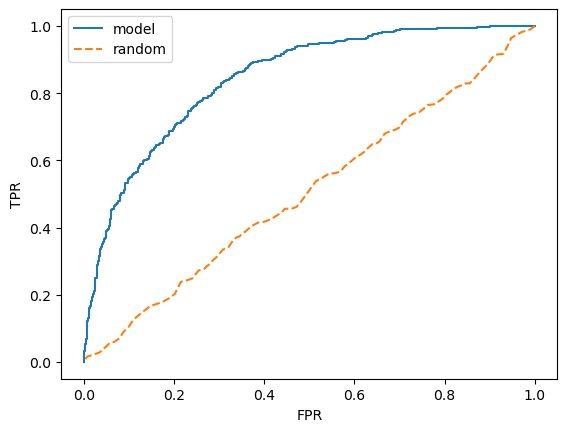

In [67]:
plt.plot(fpr, tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random', linestyle='--')
plt.legend()

plt.xlabel('FPR')
plt.ylabel('TPR')

In [25]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [41]:
auc(fpr, tpr)

0.843850505725819

In [42]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [43]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

***Calculate FPR TPR and Area under the curve in one step***

In [45]:
roc_auc_score(y_val, y_val_pred)

0.843850505725819

In [56]:
negative = y_val_pred[y_val == 0]
positive = y_val_pred[y_val == 1]

In [57]:
postive.shape

(386,)

In [55]:
import random

In [68]:
success = 0
for i in range(100000):
    pos_index = random.randint(0, len(positive)-1)
    neg_index = random.randint(0, len(negative )-1)
    
    success += 1 if positive[pos_index] > negative[neg_index] else 0

success / 100000

0.84353

In [69]:
n = 50000
np.random.seed(1)
pos_ind = np.random.randint(0, len(positive), size = n)
neg_ind = np.random.randint(0, len(negative), size = n)

(positive[pos_ind] > negative[neg_ind]).mean()

0.84646

In [33]:
def train(df, y_train, C=1.0):
    dicts = df[categorial + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df_train, dv, model):
    dicts = df_train[categorial + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred
    

In [18]:
!pip install tqdm

In [22]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [36]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [37]:
scores = []
for C in tqdm([0.001, 0.01, 0.1 , 0.5, 1, 5, 10]):
    
    for train_idx, val_idx in kfold.split(df_full_train) :
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        ## Train the model on the training dataset
        dv, model = train(df_train, y_train, C=C)
        ## Validate the model on the validation dataset
        y_pred = predict(df_val, dv, model )
        ## Evaluate the model accuracy
        scores.append(roc_auc_score(y_val, y_pred))

     
#     print(scores)
    print(C, '%.3f +- %.4f' %(np.mean(scores), np.std(scores)))
    

  0%|          | 0/7 [00:00<?, ?it/s]

0.001 0.825 +- 0.0090
0.01 0.832 +- 0.0116
0.1 0.835 +- 0.0111
0.5 0.836 +- 0.0105
1 0.837 +- 0.0101
5 0.838 +- 0.0099
10 0.838 +- 0.0096


In [39]:
## Train the model on the full training dataset
dv, model = train(df_full_train, df_full_train.churn.values, C=1)
## Validate the model on the test dataset
y_test_pred = predict(df_test, dv, model )

auc = roc_auc_score(y_test, y_test_pred)
auc

0.8572386167896259